#### In this notebook, we will 
1. Use grid search to identify p,q parameters
2. Construct a SARIMA model
3. Make predictions for the AQI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df=pd.read_csv('DataAQ/SO2-Michigan.csv',index_col=0)
df.index=pd.to_datetime(df.index)

#### Differencing parameter
- Check stationary series with ADF test
- Find 'd' for the ARIMA model

In [13]:
def adfuller_test(y,alpha=0.05):
    """
    - With the Augmented Dickey Fuller (ADF) Test, we check the stationarity of TS data    
    - To test if data is stationary, we use hypothesis testing where our null hypothesis would be “time series data is non-stationary”. 
    - We will reject null hypothesis when p-value is less than 0.05 (p-value) which makes us take alternative hypothesis “time series data is stationary”.

    """
    from statsmodels.tsa.stattools import adfuller
    dftest = adfuller(y, autolag="AIC") #autolag = Method to use when automatically determining the lag
    p_value = dftest[1]
    # print(f"p value = {p_value:0.2f}")
    if p_value < alpha:
        return f"TS Stationary.: p value = {p_value:0.2f} < {alpha:0.2f}"
        
    else:
        return f"TS non-stationary: p value = {p_value:0.2f} > {alpha:0.2f}"
        

In [14]:
def plot_1st_2nd_diffs(y,rol=10):
    """
    y: a pandas series
    """
    fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(10,13))
    y.plot(ax=ax1,label="Original",color="black")
    # add mean
    y.rolling(window=rol,center=True).mean().plot(ax=ax1,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax1.set_title(f"ADF Test: Original {adfuller_test(y=y)}")


    y.diff().plot(ax=ax2,label="1st diff",color="black")
    y.diff().rolling(window=rol,center=True).mean().plot(ax=ax2,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax2.set_title(f"ADF Test: 1st diff {adfuller_test(y=y.diff().dropna())}")

    y.diff().diff().plot(ax=ax3,label="2nd diff",color="black")
    y.diff().diff().rolling(window=rol,center=True).mean().plot(ax=ax3,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax3.set_title(f"ADF Test: 2nd diff {adfuller_test(y=y.diff().diff().dropna())}")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()

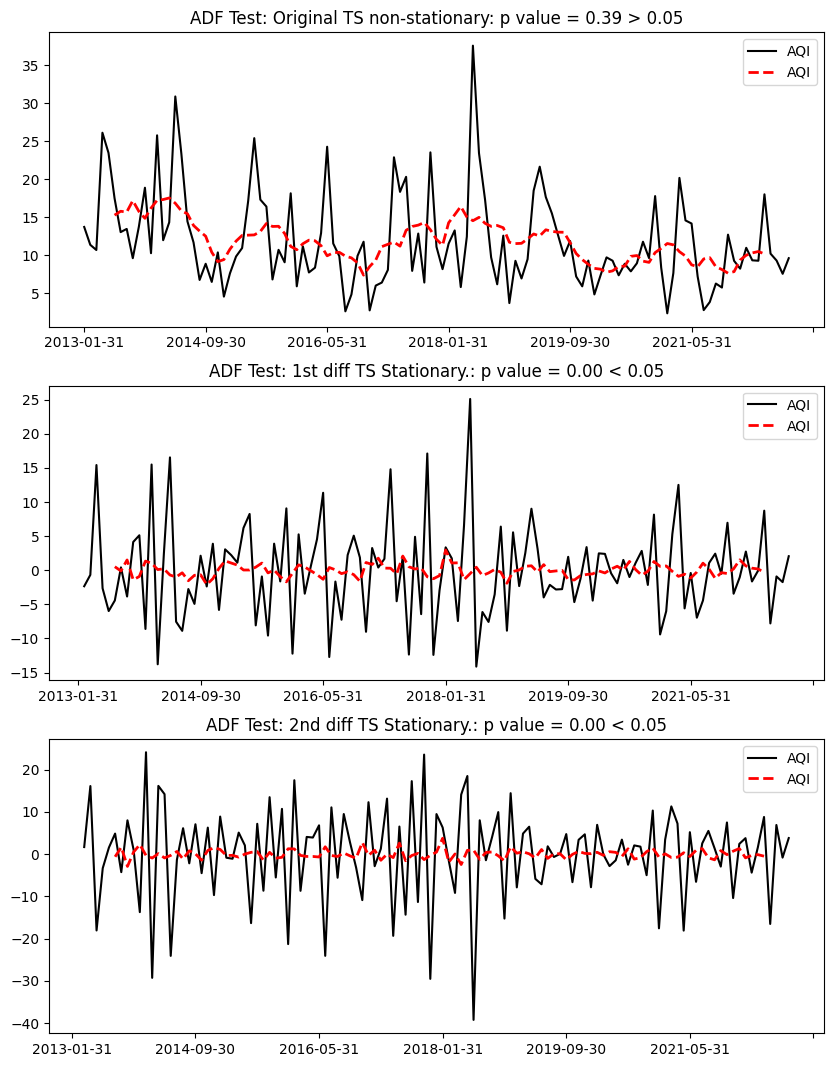

In [15]:
plot_1st_2nd_diffs(df)

#### Plot autocorrelations for original TS, and TS after 1st/2nd diff

In [16]:
def plot_acf_pacf_1st_2nd_diff(y,corr):
    """
    :param df: Data frame containing AQI data.
    :param corr: Type of correlaton: acf or pacf.
    :raise BadValueError: If corr not either acf or pacf.
    :return: ACF or PACF plots for original, 1st differenced and 2nd differnced data.
    """
    if corr not in ['acf','pacf']:
         raise ValueError('second argument must be acf or pacf')
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(10,10))
    if corr=='acf':
        plot_acf(y,ax=ax1,label="Original");
        plot_acf(y.diff().dropna(),ax=ax2,label="1st_diff");
        plot_acf(y.diff().diff().dropna(),ax=ax3,label="2nd_diff");
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show()
    if corr=='pacf':
        plot_pacf(y,ax=ax1,label="Original", method="ywm");
        plot_pacf(y.diff().dropna(),ax=ax2,label="1st_diff", method="ywm");
        plot_pacf(y.diff().diff().dropna(),ax=ax3,label="2nd_diff", method="ywm");
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show()
    



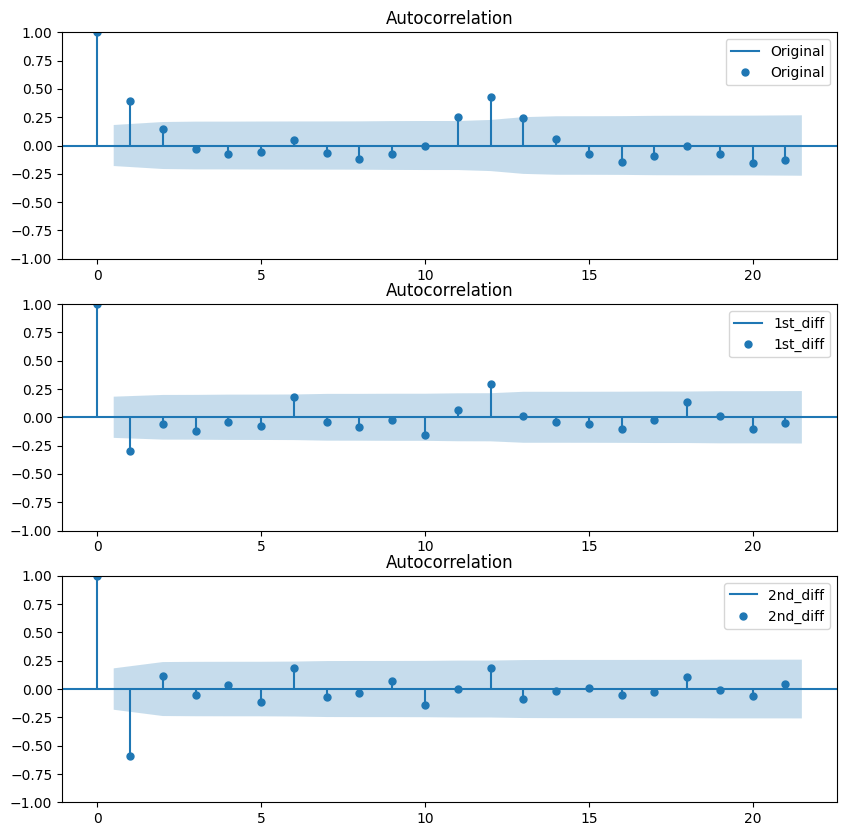

In [17]:
plot_acf_pacf_1st_2nd_diff(df,'acf')

From the stationary 1st differenced plot, initial estimate for q (MA parameter) is 2

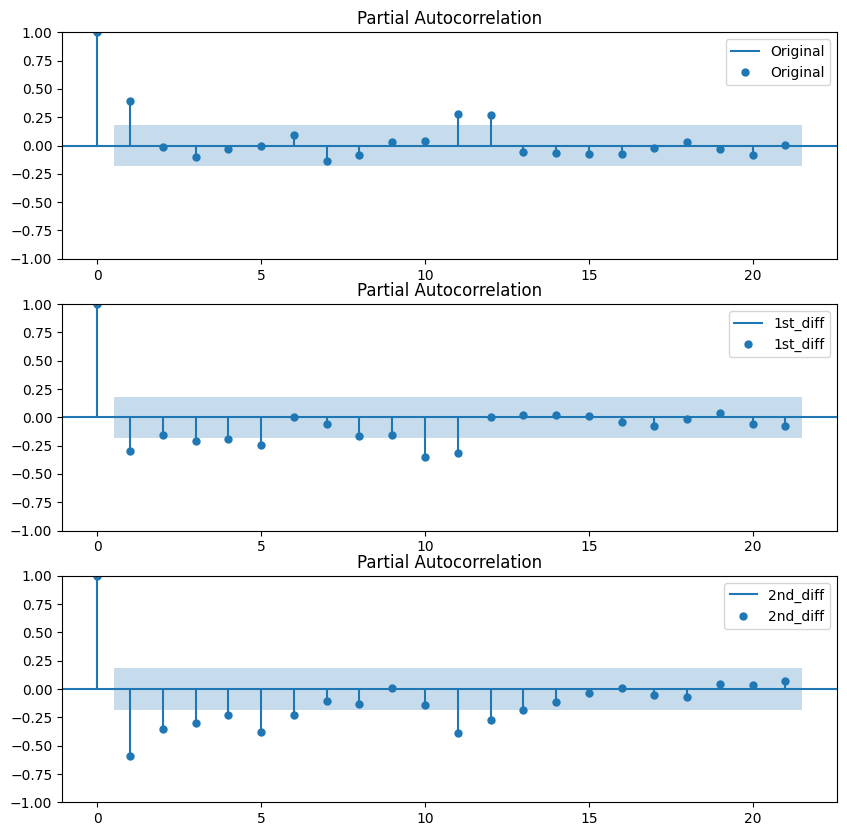

In [18]:
plot_acf_pacf_1st_2nd_diff(df,'pacf')

From the stationary 1st differenced plot, initial estimate for p (MA parameter) is 2

In [19]:
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=780.637, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=754.570, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=778.640, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=772.112, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=750.707, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=751.131, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=749.164, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=761.170, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=751.140, Time=0.61 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=755.126, Time=0.41 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=771.714, Time=0.20 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=74

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  117
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -357.520
Date:                            Mon, 06 Feb 2023   AIC                            725.039
Time:                                    18:04:46   BIC                            738.807
Sample:                                01-31-2013   HQIC                           730.628
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2545      0.123      2.073      0.038       0.014       0.495
ma.L1         -0.9725      0.029    -33.323      0.000      -1.030      -0.915
ar.S.L12       0.8931      0.093      9.612      0.000       0.711       1.075
ma.S.L12      -0.6494      0.180     -3.613      0.000      -1.002      -0.297
sigma2        26.3076      3.253      8.088      0.000      19.933      32.683
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                49.30
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.20
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

train_size=int(0.8*len(df))

train = df[:train_size]
test  = df[train_size:]

# model = ARIMA(train, order=(1, 1, 1))
model = sm.tsa.statespace.SARIMAX(train,order=(1,1,1),seasonal_order=(1,0,1,12))

fit_model = model.fit()

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [22]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                AQI   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -288.205
Date:                            Mon, 06 Feb 2023   AIC                            586.410
Time:                                    18:05:05   BIC                            599.019
Sample:                                01-31-2013   HQIC                           591.499
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2623      0.142      1.845      0.065      -0.016       0.541
ma.L1         -0.9692      0.040    -24.316      0.000      -1.047      -0.891
ar.S.L12       0.8645      0.130      6.633      0.000       0.609       1.120
ma.S.L12      -0.5998      0.238     -2.518      0.012      -1.067      -0.133
sigma2        28.8987      4.012      7.202      0.000      21.034      36.763
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                43.96
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             1.28
Prob(H) (two-sided):                  0.59   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

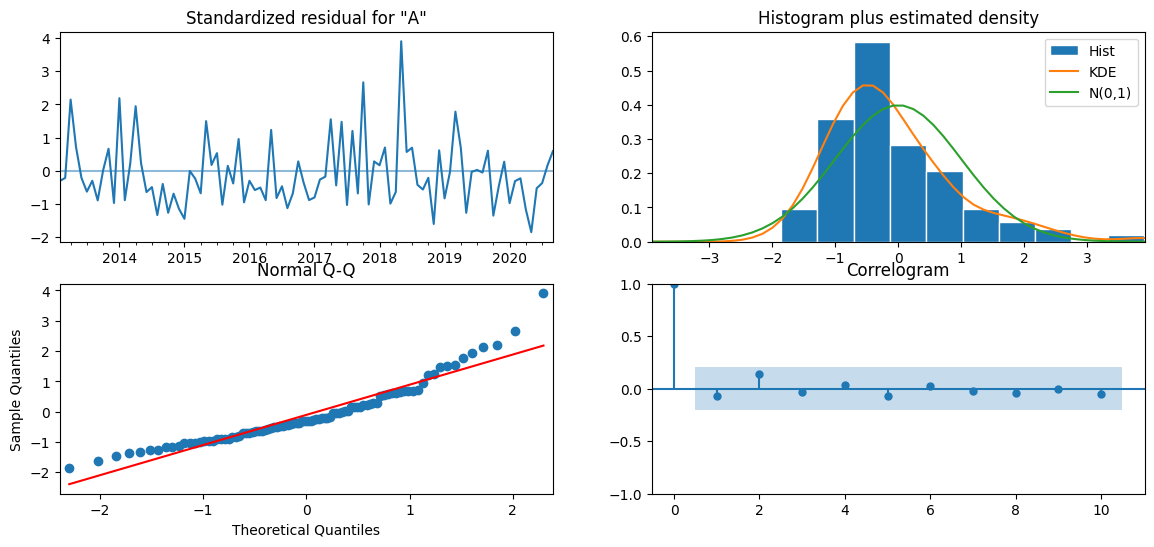

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
fit_model.plot_diagnostics();

In [24]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = len(test)
predict = fit_model.get_prediction(start='2013-02-28',end='2022-09-30')
# predict = fit_model.get_prediction(end='2022-09-30')
# idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

print(len(predict.predicted_mean),len(predict_ci))

116 116


Training data and predictions

In [41]:
print(train.head())
print('*************************')
print(predict.predicted_mean.head())

                  AQI
2013-01-31  13.741935
2013-02-28  11.392857
2013-03-31  10.709677
2013-04-30  26.133333
2013-05-31  23.483871
*************************
2013-02-28    13.741648
2013-03-31    12.258177
2013-04-30    11.660577
2013-05-31    18.793489
2013-06-30    18.926272
Freq: M, Name: predicted_mean, dtype: float64


Testing data and predictions

In [40]:
print(test.tail())
print('*************************')
print(predict.predicted_mean.tail())

                  AQI
2022-05-31  18.032258
2022-06-30  10.233333
2022-07-31   9.322581
2022-08-31   7.580645
2022-09-30   9.633333
*************************
2022-05-31    13.487382
2022-06-30    11.782125
2022-07-31     9.908703
2022-08-31     8.938195
2022-09-30     9.376143
Freq: M, Name: predicted_mean, dtype: float64


#### Out of sample forecast

In [81]:
p=fit_model.get_prediction(start='2022-09-30',end='2045-09-30')
p_ci=p.conf_int(alpha=0.5)

#### Plot original data, model predictions and confidence interval

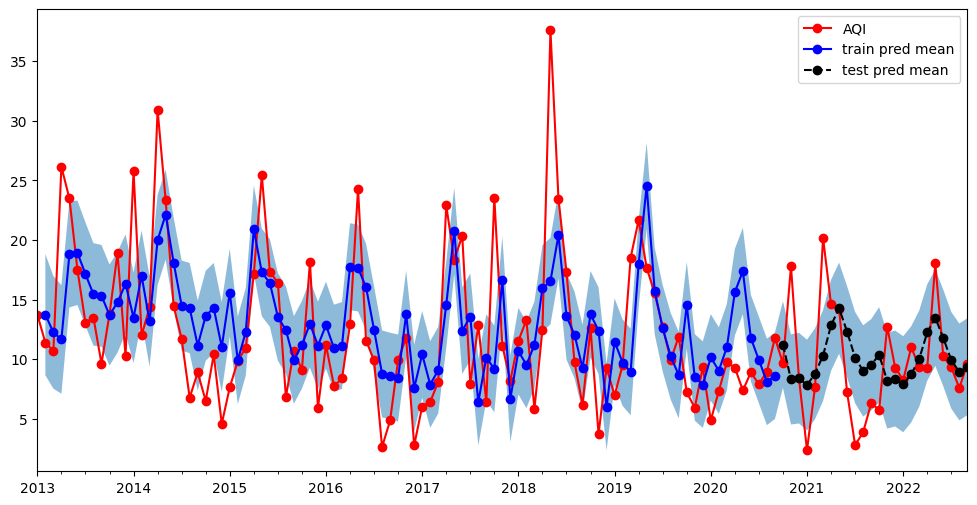

In [83]:
# # Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
df.plot(ax=ax, style='-o', label='Observed',color="red")

predict.predicted_mean[:-nforecast].plot(style='-o',color="blue",ax=ax,label="train pred mean")
predict.predicted_mean[-nforecast:].plot(style='o',color="black",linestyle='--',ax=ax,label="test pred mean")
# p.predicted_mean.plot(style='o',color="black",linestyle='--',ax=ax,label="test pred mean")
ax.fill_between(predict_ci.index, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.5)
# ax.fill_between(p_ci.index, p_ci.iloc[:, 0], p_ci.iloc[:, 1], alpha=0.5)



ax.legend()

plt.show()

In [60]:
predict_ci

,lower AQI,upper AQI
2013-02-28,8.661512,18.821785
2013-03-31,7.535406,16.980948
2013-04-30,7.111730,16.209424
2013-05-31,14.347571,23.239407
2013-06-30,14.548340,23.304205
...,...,...
2022-05-31,9.442125,17.532639
2022-06-30,7.732336,15.831915
2022-07-31,5.854386,13.963019
2022-08-31,4.879356,12.997033
